In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style = "whitegrid") 

In [3]:
# load cleaned data 

data =  pd.read_csv(r"C:\Data science work\Projects\Sales Forcasting\data\cleaned_data.csv")

# 🔹 Section 1 — Time Series Preparation(Data loading, resampling, cleaning)

Groups all rows that belong to the same date

Adds their sales

Gives one row per week

In [4]:
weekly_sales = data.groupby("Date")["Weekly_Sales"].sum().reset_index()
                     # group by date and sum the weekly sales for each date, then reset the index to get a new DataFrame with 'Date' and 'Weekly_Sales' columns

weekly_sales['Date'] = pd.to_datetime(weekly_sales['Date'])
                     # convert the 'Date' column to datetime format for easier manipulation and analysis
weekly_sales = weekly_sales.sort_values("Date") 
                     # sort the DataFrame by 'Date' in ascending order to ensure the time series is in the correct order for analysis and forecasting

In [5]:
weekly_sales.head()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


 Set Date as Index
--------------------------
Forecasting libraries expect time to be the index.

?

Now each row is identified by its time stamp.

This makes plotting and modeling easier.

In [6]:
weekly_sales.set_index("Date" , inplace =True)
# set the 'Date' column as the index of the DataFrame to facilitate time series analysis and forecasting, allowing for easier slicing and resampling based on date.

In [7]:
weekly_sales.head()

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


Check for Missing Weeks
---------------------------
Time series must be continuous. No skipped weeks.

means:

Data should occur every week

Specifically on Fridays (because Walmart data is weekly ending Friday)

If any week is missing, it will show as NaN.

In [8]:
weekly_sales = weekly_sales.asfreq('W-FRI')

that create missing value for some friday 

In [9]:
print("\nMissing Value:\n",weekly_sales.isnull().sum())


Missing Value:
 Weekly_Sales    0
dtype: int64


Handle Missing Values by using forward fill method 

forward fill(ffill)? → If one week is missing, we assume sales were similar to the previous week rather than dropping data.

📃fill any missing values in the 'Weekly_Sales' column using forward fill method, which propagates the last valid observation forward to the next valid observation, ensuring continuity in the time series data for accurate analysis and forecasting.


In [10]:
weekly_sales['Weekly_Sales'] = weekly_sales['Weekly_Sales'].fillna('ffill') 

In [11]:
print("\nMissing Value:\n",weekly_sales.isnull().sum())


Missing Value:
 Weekly_Sales    0
dtype: int64


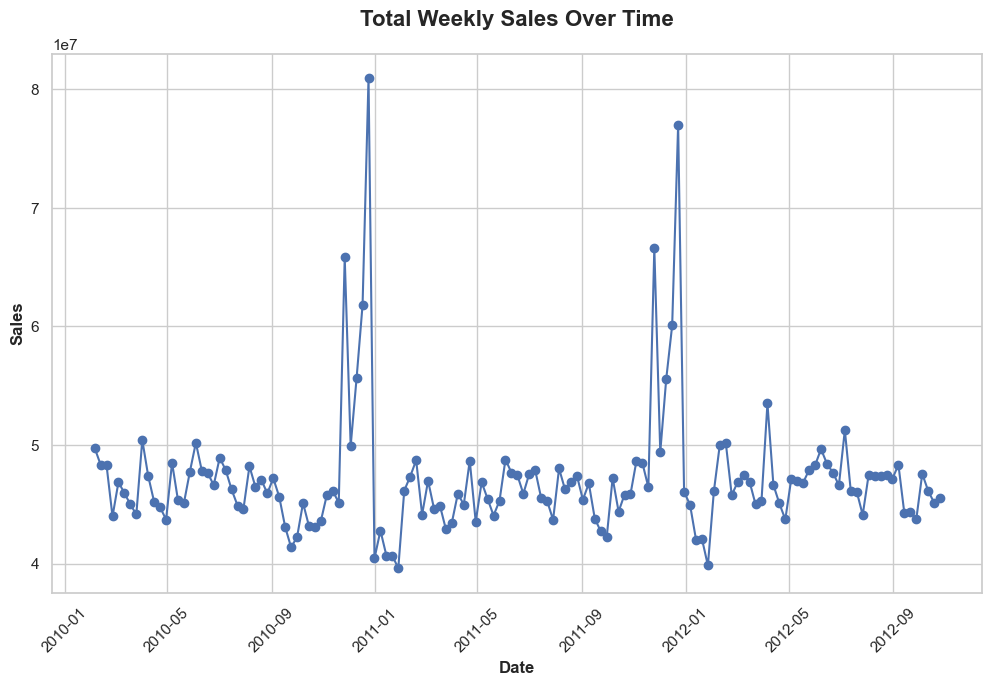

In [12]:
plt.figure(figsize=(12,7))

plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'], marker='o')
plt.title("Total Weekly Sales Over Time",fontsize=16, weight ="bold",pad =20)
plt.xticks(rotation=45)
plt.xlabel('Date',weight ="bold")
plt.ylabel("Sales",weight ="bold")
plt.show()

In [13]:
weekly_sales['rolling_12'] = weekly_sales['Weekly_Sales'].rolling(window=12).mean()

A rolling mean of 12 weeks means:

“To calculate the average at a given week, I need the previous 12 weeks of data.”

pandas cannot compute a 12-week average until it has 12 values.

That’s why the first 11 rows show NaN (Missing value).

In [14]:
weekly_sales.head()

,Weekly_Sales,rolling_12
Date,,
2010-02-05,49750740.50,NaN
2010-02-12,48336677.63,NaN
2010-02-19,48276993.78,NaN
2010-02-26,43968571.13,NaN
2010-03-05,46871470.30,NaN


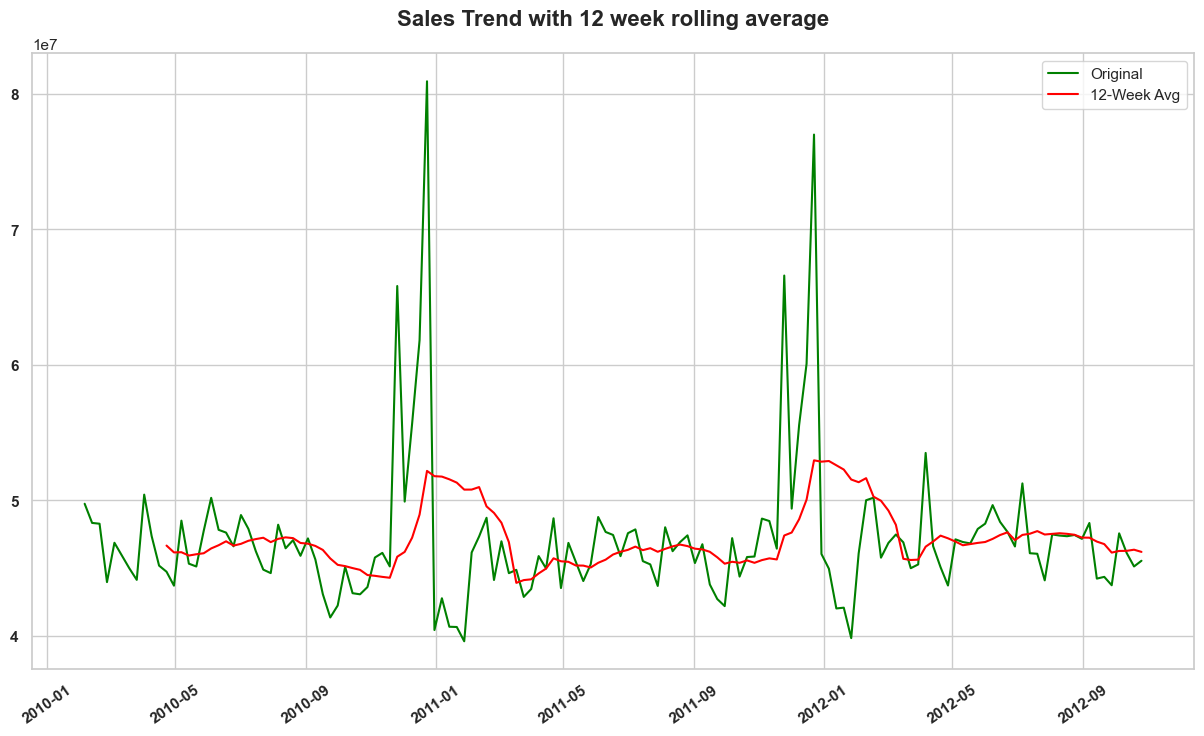

In [15]:
plt.figure(figsize=(15,8))

plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'],label='Original',color ='green')
plt.plot(weekly_sales.index, weekly_sales['rolling_12'] ,label='12-Week Avg',color = 'red')
plt.legend()
plt.xticks(rotation =35,weight ='bold')
plt.yticks(weight ="bold")
plt.title("Sales Trend with 12 week rolling average", fontsize = 16,weight ="bold", pad =20)
plt.show()

The red rolling-average line shows:

A rise toward the end of each year

A drop right after the new year

Then stable mid-year performance

This means:

"Sales follow a repeating yearly pattern, not a steady upward trend".

⬆️ 
Why This Matters for Forecasting ❔

Before building ARIMA, we must check a rule called stationarity.

What is Stationarity?

A time series is stationary if:

Mean stays roughly constant

Variance stays constant

No strong repeating seasonal trend

Your Data?

✖️ Not stationary

Because:

Mean changes across the year

Clear seasonal peaks

Trend + seasonality present

So we cannot directly apply ARIMA yet.

We must first remove trend and seasonality.

✅ Next

Next step in forecasting:

➤ Differencing

Differencing removes trend by subtracting previous values:

# Yt′​=Yt​−Yt−1​ 

| Symbol    | Meaning                               |
| --------- | ------------------------------------- |
| (Y_t)     | Sales this week                       |
| (Y_{t-1}) | Sales last week                       |
| (Y'_t)    | Change in sales compared to last week |

This helps stabilize the mean.

In [16]:
weekly_sales['diff_1'] = weekly_sales['Weekly_Sales'].diff()
weekly_sales = weekly_sales.dropna()
weekly_sales.head()

,Weekly_Sales,rolling_12,diff_1
Date,,,
2010-04-23,44734452.56,46663335.57,-449214.52
2010-04-30,43705126.71,46159534.42,-1029325.85
2010-05-07,48503243.52,46173414.91,4798116.81
2010-05-14,45330080.20,45927838.78,-3173163.32
2010-05-21,45120108.06,46023800.19,-209972.14


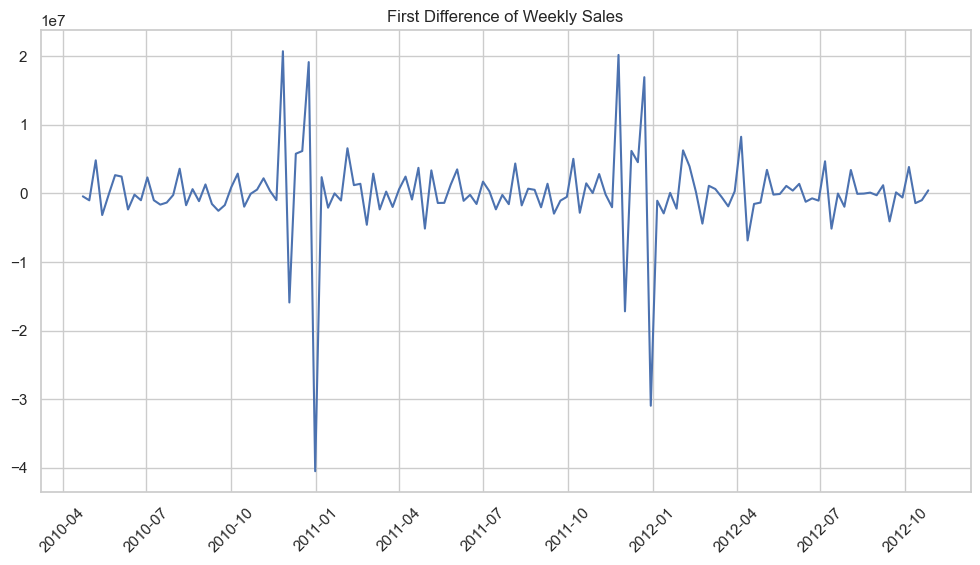

In [17]:
plt.figure(figsize=(12,6))


plt.plot(weekly_sales['diff_1'])
plt.title("First Difference of Weekly Sales")
plt.xticks(rotation=45)
plt.show()

# 🔹Section 2 — Stationarity Check (Differencing + ADF test)

ADF Test [Augmented Dickey-Fuller Test]

The test checks: “Is the data just random fluctuations around a constant mean,
or does it still have a trend?”

in simple words health check up before we move to ARIMA [the actual prediction model] 
| If p-value   | Meaning                | Can we use ARIMA?        |
| ------------ | ---------------------- | ------------------------ |
| **p < 0.05** | Data is stationary     | ✅ Yes                    |
| **p > 0.05** | Data is NOT stationary | ❌ Need more differencing |

p-value = Probability that the data still has a trend.

If it’s very small → trend is gone → ARIMA can be used.


📦 Import the ADF Test Function
---------------------------------------------------

This function performs the Augmented Dickey-Fuller test to check stationarity.

In [18]:
from statsmodels.tsa.stattools import adfuller as adf

In [19]:
weekly_sales['diff_1'].isnull().sum()

np.int64(0)

📦 Drop Missing Values

ADF cannot run if there are missing values.

In [20]:
diff_series = weekly_sales['diff_1'].dropna()

📦Run the ADF Test

This runs the statistical test.

In [21]:
adf_result = adf(diff_series)

📦 Print and Understand Results

| Index           | Meaning                    | What it tells you                                                       |
| --------------- | -------------------------- | ----------------------------------------------------------------------- |
| `adf_result[0]` | **ADF Statistic**          | How strongly the data rejects non-stationarity (more negative = better) |
| `adf_result[1]` | **p-value**                | Probability the data is *not* stationary                                |
| `adf_result[2]` | Lags used                  | How many past values the test used internally                           |
| `adf_result[3]` | Observations               | Number of data points used in the test                                  |
| `adf_result[4]` | **Critical values (dict)** | Thresholds for deciding stationarity                                    |
| `adf_result[5]` | Info criterion             | Internal metric, not needed for decisions                               |


In [22]:
print("ADF Statistics:", adf_result[0])
print("p-value:",adf_result[1])
 
print("number of lag used :", adf_result[2])
print("number of observation used :", adf_result[3])

print("\n critical values:\n")
for key, value in adf_result[4].items():
    print(f"{key}:{value}")


ADF Statistics: -6.432084895921247
p-value: 1.6876198196473397e-08
number of lag used : 7
number of observation used : 124

 critical values:

1%:-3.484219653271961
5%:-2.885145235641637
10%:-2.579359138917794


# 🔹 Section 3 — ACF & PACF(Parameter identification)
ARIMA model has form:

ARIMA(p,d,q)

You already found d = 1.

Now:

PACF → tells p

ACF → tells q

These Plots Show

Both graphs measure correlation, but in different ways.

🔵 ACF — AutoCorrelation Function [ACF helps us choose q (MA part)]

This shows:

How much today’s value is related to previous values (lags)

Lag = how many weeks back we look. 
| Lag   | Meaning         |
| ----- | --------------- |
| Lag 1 | Last week       |
| Lag 2 | Two weeks ago   |
| Lag 3 | Three weeks ago |


🟢 PACF — Partial AutoCorrelation Function

This shows:

The direct relationship between today and previous weeks, removing indirect effects.

PACF helps us choose p (AR part).

📦 Code to Plot ACF & PACF
-----------------------------------------------------------------------------------------

<Figure size 1200x500 with 0 Axes>

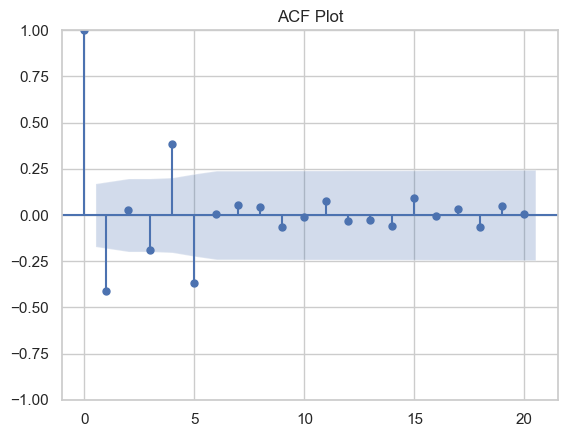

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(weekly_sales['diff_1'].dropna(), lags = 20)
plt.title("ACF Plot")
plt.show()

📊 Reading ACF Plot (for q)

ACF tells us about the MA (Moving Average) part → value of q

we see:

Lag 1 → big negative spike (outside blue band) ✔

Lag 2–4 → some spikes, but pattern starts weakening

After lag ~5 → mostly inside the confidence band

Interpretation:

ACF shows a strong spike at lag 1, then it quickly dies down.

That pattern suggests:

q = 1

Meaning: last week’s error affects this week.

<Figure size 1200x500 with 0 Axes>

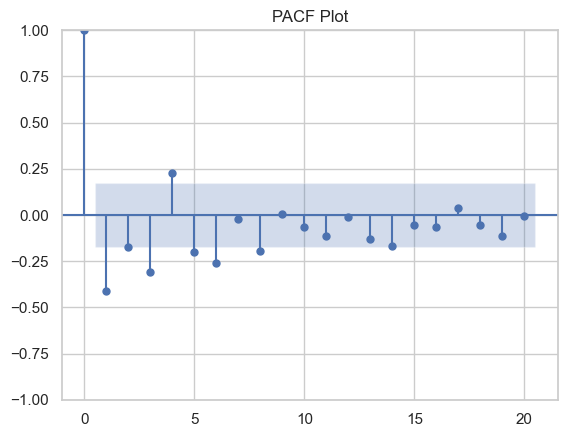

In [24]:
plt.figure(figsize=(12,5))
plot_pacf(weekly_sales['diff_1'].dropna(), lags = 20)
plt.title("PACF Plot")
plt.show()

📊 Reading YOUR PACF Plot (for p)

PACF tells us about the AR (AutoRegressive) part → value of p

What we see:

Lag 1 → strong negative spike ✔

Lag 2–3 → still noticeable

After lag ~3–4 → mostly inside band

Interpretation:

PACF has significant spikes up to lag 3, then cuts off.

That suggests:

p = 2 or 3

When PACF tapers after lag 2–3, we test both options.

🧠 Putting It Together

We already found:

d = 1 (from differencing)

From ACF & PACF:

p = 2 or 3

q = 1

🎯 Candidate ARIMA Models

We usually test a few close combinations:

1️⃣ ARIMA(2,1,1)

2️⃣ ARIMA(3,1,1)

These are your primary candidates.

🧠 What This Means in Simple Words

Your sales changes are influenced by:

The last 2–3 weeks of sales patterns (AR part)

The last week’s forecasting error (MA part)

So the model needs memory of recent weeks.

# 🔹 Section 4 — ARIMA Modeling (Fit ARIMA, evaluate, forecast)

In [25]:
from statsmodels.tsa.arima.model import ARIMA as ar 

📦 Step 2 Prepare the Sales Series

Why?

ARIMA applies differencing internally using d = 1.

In [26]:
sales_series = weekly_sales['Weekly_Sales'] 

🏗 Step 3 — Build ARIMA(2,1,1)

In [27]:

model_211 = ar(sales_series, order=(2,1,1), # specify the order of the ARIMA model with p=2, d=1, q=1
               enforce_stationarity=False,  # allow the model to be fitted even if the stationarity condition is not met,
                                            # which can be useful when working with non-stationary time series data
               enforce_invertibility=False  # allow the model to be fitted even if the invertibility condition is not met,
                                            # which can be useful when working with non-invertible time series data
               )

model_211_fit = model_211.fit( 
    method_kwargs={"maxiter": 200} # increase the maximum number of iterations for the optimization algorithm to ensure convergence when fitting the ARIMA model,
                                   # especially for more complex models or larger datasets.
    )

In [28]:
print(model_211_fit.aic)

4369.699793243046


In [29]:
print(model_211_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  132
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2180.850
Date:                Tue, 10 Feb 2026   AIC                           4369.700
Time:                        14:50:35   BIC                           4381.139
Sample:                    04-23-2010   HQIC                          4374.348
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0982      0.090      1.096      0.273      -0.077       0.274
ar.L2         -0.0146      0.095     -0.153      0.879      -0.202       0.172
ma.L1         -1.0638      0.029    -36.586      0.0

In [30]:
forcast_211 = model_211_fit.forecast(steps=12) # generate forecasts for the next 12 time steps using the fitted ARIMA model plot
forcast_211

2012-11-02   46899182.31
2012-11-09   47026067.65
2012-11-16   47018776.06
2012-11-23   47016211.03
2012-11-30   47016065.48
2012-12-07   47016088.57
2012-12-14   47016092.96
2012-12-21   47016093.05
2012-12-28   47016093.00
2013-01-04   47016092.99
2013-01-11   47016092.99
2013-01-18   47016092.99
Freq: W-FRI, Name: predicted_mean, dtype: float64

 📈 Step 6 — Plot Forecast

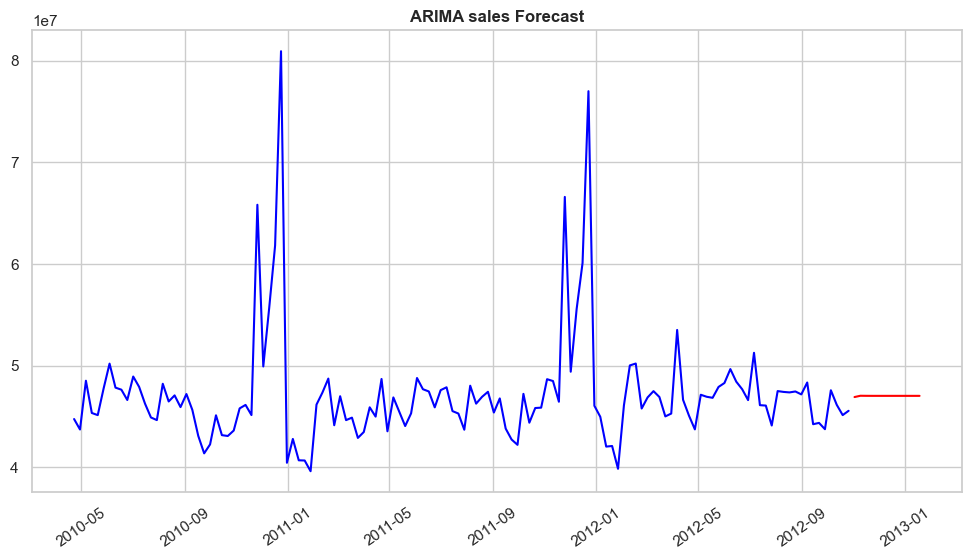

In [31]:
plt.figure(figsize=(12,6))

plt.plot(sales_series, label = 'Historical Sales', color = 'Blue')
plt.plot(forcast_211, label = 'Forecast(ARIMA 2,1,1)', color='red')

plt.xticks(rotation = 35)
plt.title("ARIMA sales Forecast", weight ='bold')
plt.show()
# The ARIMA(2,1,1) model is a time series forecasting model that combines autoregressive (AR) and moving average (MA) components with differencing to make the time series stationary. In this case, the model is fitted to the historical sales data, and then it is used to forecast future sales for the next 12 time steps. The resulting forecast can be visualized alongside the historical sales data to assess the model's performance and make informed decisions based on the predicted sales trends.

🧪 Step 7 — ARIMA(3,1,1) for Comparison

Lower AIC = better fit 

In [32]:
model_311 = ar(sales_series, order = (3,1,1))
model_311_fit = model_311.fit()

In [33]:
print(model_311_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  132
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2224.028
Date:                Tue, 10 Feb 2026   AIC                           4458.055
Time:                        14:50:36   BIC                           4472.431
Sample:                    04-23-2010   HQIC                          4463.897
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8087      0.213     -3.804      0.000      -1.225      -0.392
ar.L2         -0.3552      0.073     -4.888      0.000      -0.498      -0.213
ar.L3         -0.2773      0.037     -7.545      0.0

In [34]:
print("AIC ARIMA(3,1,1):",model_311_fit.aic)
print("AIC ARIMA(2,1,1):",model_211_fit.aic)

AIC ARIMA(3,1,1): 4458.055094370378
AIC ARIMA(2,1,1): 4369.699793243046


# 🔹 Section 5 — SARIMA Modeling (Fit SARIMA, evaluate, forecast)
📈 What is SARIMA?

SARIMA = Seasonal ARIMA

Normal ARIMA handles:

Trend

Short-term patterns

SARIMA also handles:

Seasonal cycles (like yearly holiday spikes)

Model format:

SARIMA(p,d,q)×(P,D,Q,s)

Where:

(p,d,q) → regular ARIMA part

(P,D,Q) → seasonal part

s → length of seasonal cycle

For weekly retail data:

 weeks

s=52 weeks

📦 Step 1 — Import SARIMAX

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as srx
# SARIMAX is the statsmodels class used to build SARIMA models.

📦 Step 2 — Use the Original Sales Series

Why not differenced data?

SARIMA automatically applies differencing:

d=1 removes trend

D=1 removes seasonal trend

In [36]:
sales_series = weekly_sales['Weekly_Sales']

⚙ Step 3 — Define the SARIMA Model
| Parameter | Meaning                                    |
| --------- | ------------------------------------------ |
| **p=2**   | Last 2 weeks influence current week        |
| **d=1**   | Remove overall trend                       |
| **q=1**   | Last week's error influences current       |
| **P=1**   | Last year’s same week influences this week |
| **D=1**   | Remove yearly seasonal trend               |
| **Q=1**   | Last year’s seasonal error influence       |
| **s=52**  | One year = 52 weeks                        |

This allows the model to learn:

Short-term sales behavior

Yearly holiday patterns

In [37]:
sarima_model = srx(sales_series,
                   order =(2,1,1), # non-seasonal order (p,d,q
                   seasonal_order=(1,1,1,52), # seasonal order (P,D,Q,s) where s is the seasonal period (e.g., 12 for monthly data, 52 for weekly data
                   enforce_stationarity= False,
                   enforce_invertibility=False
                   )

In [38]:
sarimax_fit = sarima_model.fit()
print(sarimax_fit.summary())

c:\Data science work\Projects\Sales Forcasting\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -387.855
Date:                            Tue, 10 Feb 2026   AIC                            787.709
Time:                                    14:50:54   BIC                            795.023
Sample:                                04-23-2010   HQIC                           789.738
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5069      0.784     -0.647      0.518      -2.044       1.030
ar.L2         -0.1228      0.733   

In [39]:
print("SARIMAX AIC", sarimax_fit.aic)
print("ARIMA 211",model_211_fit.aic)

SARIMAX AIC 787.7094146720723
ARIMA 211 4369.699793243046


🔮 Step 6 — Forecast Future 12 Weeks

In [40]:
sarimax_forcast = sarimax_fit.forecast(steps =12)

# 📈 Step 7 — Plot Forecast vs History

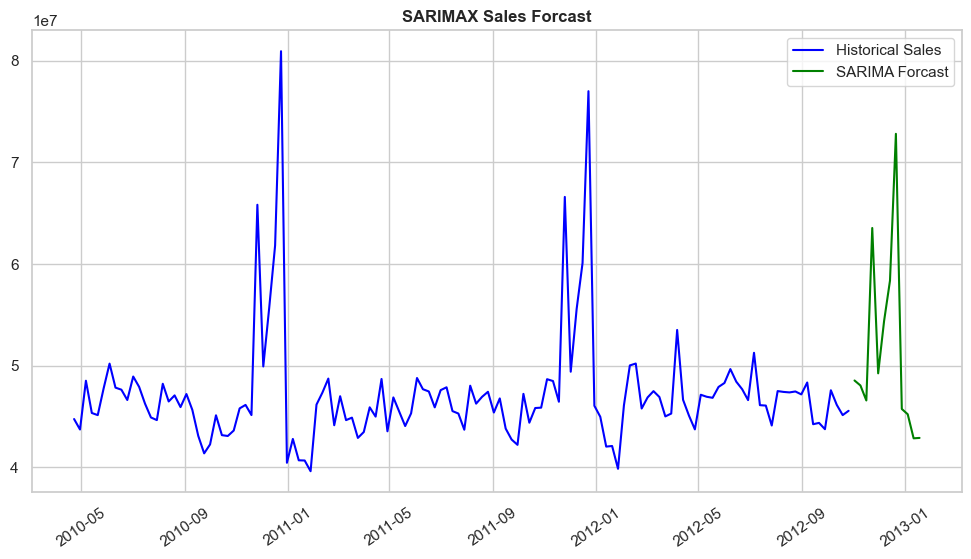

In [41]:
plt.figure(figsize=(12,6))

plt.plot(sales_series, label = "Historical Sales", color = 'blue')
plt.plot(sarimax_forcast, label = 'SARIMA Forcast', color = 'green')

plt.title("SARIMAX Sales Forcast", fontsize = 12 ,weight = 'bold')
plt.xticks(rotation = 35)
plt.legend()
plt.show()

# 📊 Model Accuracy Evaluation (Train/Test Forecasting)

🎯 Goal

Test how well SARIMA predicts real unseen sales.

We simulate real life:

Train on past data

Predict future

Compare with actual sales

In [42]:
train = sales_series[:-12] # use all but the last 12 data points for training the model
test = sales_series[-12:]  # use the last 12 data points as the test set to evaluate the model's forecasting performance on unseen data,
                           # allowing for a more realistic assessment of how well the model can predict future sales based on historical patterns.

In [43]:
# Fit SARIMA on Training Data Only

sarima_model = srx (
    train,
    order=(2,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()




c:\Data science work\Projects\Sales Forcasting\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Data science work\Projects\Sales Forcasting\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🔮 Step 3 — Forecast for the SAME Dates as Test Set

 generate predictions for the test set using the fitted SARIMA model, starting from the first index of the test set and ending at the last index of the test set, allowing for a direct comparison between the predicted values and the actual values in the test set to evaluate the model's forecasting performance.

 This makes sure:

Forecast dates = Test dates

We compare the same weeks

In [55]:
forecast = sarimax_fit.predict(start=test.index[0], end=test.index[-1])
 

📊 Step 4 — Plot Forecast vs Actual

Visual comparison helps us see:

Trend alignment

Seasonal pattern matching

Forecast lag or bias

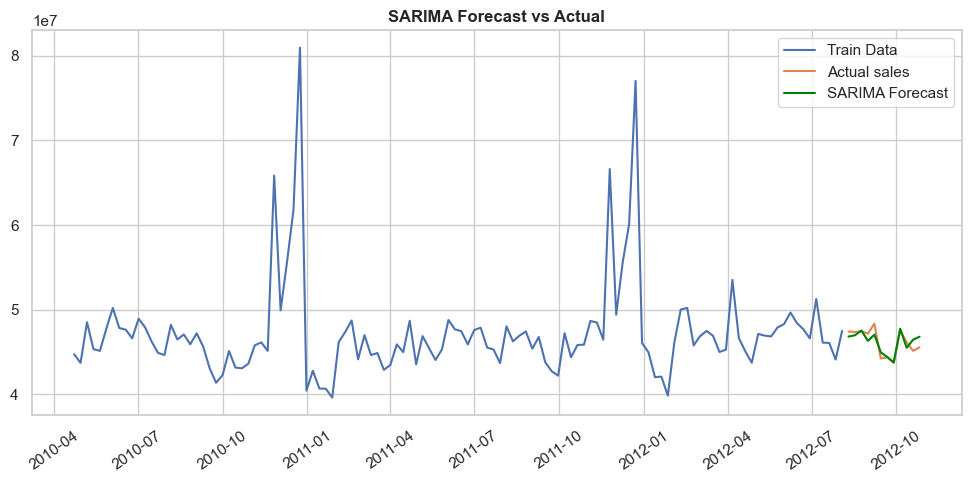

In [56]:


plt.figure(figsize=(12,5))

plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual sales')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='green')

plt.xticks(rotation = 35)

plt.title('SARIMA Forecast vs Actual', weight = 'bold')
plt.legend()
plt.show()


# 🧮 Calculate Error Metrics

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [58]:
print("Mean Absolute Error:", mean_absolute_error(test, forecast))
print("mean squared error:",mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test.replace(0, np.nan))) * 100
print("MAPE:", mape)



Mean Absolute Error: 613853.0397874551
mean squared error: 596028439371.8009
MAPE: 1.3249440640141974


In [60]:
print("Zeros in test:", (test == 0).sum())
print("NaNs in test:", test.isna().sum())
print("NaNs in forecast:", forecast.isna().sum())


Zeros in test: 0
NaNs in test: 0
NaNs in forecast: 0


In [61]:
print("Test index sample:", test.index[:5])
print("Forecast index sample:", forecast.index[:5])


Test index sample: DatetimeIndex(['2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
               '2012-09-07'],
              dtype='datetime64[us]', name='Date', freq='W-FRI')
Forecast index sample: DatetimeIndex(['2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
               '2012-09-07'],
              dtype='datetime64[us]', name='Date', freq='W-FRI')
